# Result VCT regression

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from phd.visualization.bokeh_plotting import create_tab
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
    
from phd.pipelines.predict.nodes import score

Loading BokehJS ...

In [4]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
model_loaders = catalog.load(f"{ship}.models_VCT_MDL")

df_VCT_scaled = catalog.load(f"{ship}.df_VCT_scaled")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

[01/18/24 18:19:58] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=163817;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=233465;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/par ]8;id=762959;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=151429;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             titioned_dataset.py:200: KedroDeprecationWarning: 'PartitionedDataset'                
                             has been moved to `kedro-datasets` and will be removed in Kedro                       
                             0.19.0.                                                                               
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__i ]8;id=699295;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=478273;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             nit__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                      
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=330188;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=450832;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=371610;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=536679;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=70839;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=104808;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=844714;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=847908;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=234266;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=132894;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [85]:
model = model_loaders['semiempirical_covered']()

## Compare with MDL inverse dynamics
The forces from model tests in MDL can be estimated with inverse dynamics. These forces can be compared with forces predicted with the regressed models.

In [86]:
def preprocess(data_MDL):
    data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
    data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
    data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
    data_MDL['twa']=0
    data_MDL['tws']=0
    data_MDL['theta']=0
    data_MDL['q']=0
    data_MDL['phi'] = data_MDL['roll']
    data_MDL['p'] = 0
    data_MDL['q1d'] = 0
    data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
    data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
    
    return data_MDL

In [115]:
#id = 22773
id = 22772
#id = 22770
#id = 22764
#id = 22774
#id = 22616  # Spiral


data_MDL = tests_ek_smooth[f'{id}']()
data_MDL_ek = tests_ek[f'{id}']()
preprocess(data_MDL)
preprocess(data_MDL_ek)

,x0,y0,psi,u,v,r,u1d,v1d,r1d,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,z0,V,U,thrust,rev,twa,tws,thrust_port,thrust_stbd,beta,theta,q,phi,p,q1d
0.000000,0.010682,8.082920e-07,-0.000611,0.972889,0.000603,8.844824e-07,-0.159545,-0.000309,0.045773,0.0,1.0,2.146755,0.000027,0.187446,0.0,-0.520477,10.131507,1.0,2.146755,-0.000706,0.231210,0.0,-8.160022,11.329219,0.021273,-0.030895,0.007658,0.015050,-0.007220,0.012022,9.558658,5.450189,-0.108403,9.564930,5.347577,0.100852,0.000014,0.645772,14.89,-0.000144,0.1,0.0,0.000125,0.000890,-0.000171,0.002476,0.972889,0.972889,10.797766,9.561794,0,0,5.450189,5.347577,-0.000620,0,0,0.000890,0,0
0.009931,0.017082,1.129842e-06,-0.000579,0.971305,0.000600,4.554541e-04,-0.037431,0.000054,-0.029367,0.0,1.0,2.146755,0.000035,0.037287,0.0,0.212813,10.131507,1.0,2.146755,-0.000929,0.206990,0.0,-6.481174,11.329219,-0.010323,0.089009,0.017337,0.033088,0.010187,0.044245,9.574600,5.416779,-0.111748,9.556027,5.263566,0.099891,0.000014,0.645772,14.89,-0.000190,0.1,0.0,0.000125,0.000850,0.000083,0.002564,0.971305,0.971305,10.680344,9.565313,0,0,5.416779,5.263566,-0.000618,0,0,0.000850,0,0
0.019862,0.027371,1.269224e-06,-0.000618,0.972146,0.000605,-5.823960e-04,-0.123344,0.000106,-0.045940,0.0,1.0,2.146755,0.000044,-0.170115,0.0,-0.366100,10.131507,1.0,2.146755,-0.001154,0.015996,0.0,-5.689993,11.329219,-0.014837,0.063223,0.017983,0.046616,0.009542,0.031356,9.653423,5.444381,-0.114711,9.565278,5.233857,0.100988,0.000020,0.645772,14.89,-0.000236,0.1,0.0,0.000125,0.000868,-0.000135,0.002566,0.972146,0.972146,10.678238,9.609350,0,0,5.444381,5.233857,-0.000622,0,0,0.000868,0,0
0.029793,0.035466,1.564520e-06,-0.000619,0.968855,0.000603,-4.570101e-04,-0.381859,-0.000256,0.012217,0.0,1.0,2.146755,0.000052,-0.285948,0.0,-0.173129,10.131507,1.0,2.146755,-0.001382,-0.180430,0.0,0.157031,11.329219,0.005152,0.072248,0.005076,0.054991,0.022437,0.019756,9.623491,5.517160,-0.116242,9.534870,5.259566,0.103520,0.000014,0.645772,14.89,-0.000283,0.1,0.0,0.000125,0.000850,0.000102,0.002481,0.968855,0.968855,10.776726,9.579180,0,0,5.517160,5.259566,-0.000622,0,0,0.000850,0,0
0.039724,0.043711,1.843651e-06,-0.000619,0.964561,0.000599,-3.397351e-04,-0.373160,-0.000313,0.010546,0.0,1.0,2.146755,0.000061,-0.218993,0.0,0.367190,10.131507,1.0,2.146755,-0.001606,-0.232356,0.0,-1.830571,11.329219,-0.010968,0.065157,0.014756,0.029223,0.016634,0.015245,9.603952,5.616301,-0.115943,9.572603,5.323262,0.106590,0.000014,0.645772,14.89,-0.000329,0.1,0.0,0.000125,0.000831,-0.000185,0.002655,0.964561,0.964561,10.939563,9.588278,0,0,5.616301,5.323262,-0.000622,0,0,0.000831,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71.016581,55.472342,1.215794e+00,-0.193415,0.776614,-0.085287,5.572480e-02,0.025440,-0.017753,0.007436,0.0,1.0,2.146755,0.057269,-0.106522,0.0,-0.153832,10.131507,1.0,2.146755,-1.515974,-0.015793,0.0,-1.946354,11.329219,-0.001941,0.100613,-0.004603,0.022781,-0.002063,-0.012466,9.511381,7.392989,-0.139509,9.580544,5.423067,0.113880,-0.349072,0.645772,14.89,-0.310125,0.1,0.0,-0.000550,-0.007266,-0.000066,0.001469,0.781283,0.781283,12.816056,9.545963,0,0,7.392989,5.423067,0.109380,0,0,-0.007266,0,0
71.026512,55.479876,1.213440e+00,-0.192861,0.776851,-0.085457,5.578257e-02,0.005256,-0.015183,-0.001356,0.0,1.0,2.146755,0.057201,-0.098690,0.0,0.039139,10.131507,1.0,2.146755,-1.514175,-0.025439,0.0,4.769040,11.32

In [116]:
models = {
    'Reference model': model,    
}

In [117]:
#a = 3
#model.parameters['Nr']=-0.0011355289219342403*0.5*a
#model.parameters['Nv']=-0.0029190394876494473

[01/18/24 18:48:43] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=58577;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=766408;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_2426/2301622738.py:5: UserWarning: The figure layout    ]8;id=908712;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=832072;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

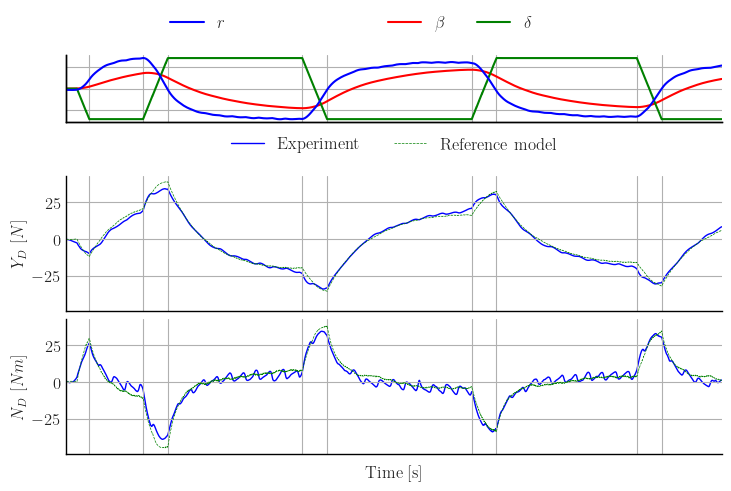

In [118]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['Y_D','N_D'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.pdf"))

In [119]:
model = models['Reference model']

In [120]:
data = data_MDL
forces_from_motions = model.forces_from_motions(data=data)
df_predict = predict(model=model, data=data)

<Axes: >

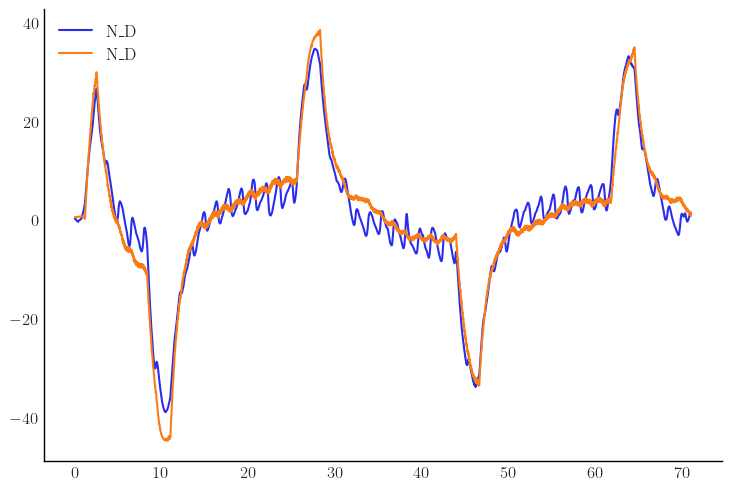

In [121]:
fig,ax=plt.subplots()
forces_from_motions.plot(y='N_D',ax=ax)
df_predict.plot(y='N_D', ax=ax)

## Other tests

In [122]:
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")

[01/18/24 18:48:45] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=456046;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=178288;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [123]:
_ = []
ids = tests_ek_smooth_joined['id'].unique()
for id in ids:
    
    loader = tests_ek_smooth[str(id)]
    data = loader()
    preprocess(data)
    try:
        s = score(model=model, data=data)
    except:
        print(f"Skipping {id}")
        continue
        
    _.append(pd.Series(s, name=id))
    
df_scores = pd.DataFrame(_)

In [124]:
steals = [
    'test_type',
    'angle1',
    'ship_speed',
]
for steal in steals:
    df_scores[steal] = time_series_meta_data[steal]

In [125]:
mask = df_scores['test_type'] == 'rodergrundvinkel'
df_scores.loc[mask,'test_type'] = 'yaw rate'

mask = df_scores['test_type'] == 'reference speed'
df_scores.loc[mask,'test_type'] = 'ref. speed'

mask = df_scores['test_type'] == 'zigzag'
df_scores.loc[mask,'Description'] = df_scores.loc[mask].apply(lambda x:f"{x['test_type']}{int(x['angle1'])}/{int(x['angle1'])}", axis=1)
df_scores.loc[~mask,'Description'] = df_scores.loc[~mask,'test_type']

In [126]:
df_scores.sort_values(by=['Description','ship_speed'], inplace=True, ascending=False)

In [127]:
df_scores_table = df_scores[['Description','ship_speed','X_D','Y_D','N_D']].copy()
df_scores_table.rename(columns={
    'ship_speed': r'V',
    'X_D': r'$X_D$ $[N]$',
    'Y_D': r'$Y_D$ $[Nm]$',
    'N_D': r'$N_D$ $[Nm]$',
    
}, inplace=True)

In [128]:
df_scores_table.to_csv(paper.file_path_with_nb_ref("reference_model_mean_average_error.csv", directory='tables'), index=False)

In [129]:
df_scores_table

,Description,V,$X_D$ $[N]$,$Y_D$ $[Nm]$,$N_D$ $[Nm]$
22772,zigzag20/20,0.96177,1.061610,1.432577,2.497856
22773,zigzag20/20,0.96177,1.123392,1.521672,2.527094
22764,zigzag10/10,0.96177,1.390034,1.455863,1.783432
22770,zigzag10/10,0.96177,1.377763,1.193526,1.898771
